In [1]:
using ramnet
using ramnet.Models: predict_response, BleachingDiscriminator
using ramnet.Utils: stack, accuracy, ambiguity
using Images
using MLDatasets
using BenchmarkTools

# An Introduction to Weightless Neural Networks

## 1. An initial example

As a first example of how we can employ weightless models, let's tackle the task of distinguishing two characters in 3x3 pixel images: the 'T' and 'H' characters.Below we can see the two images we will be using as training examples:

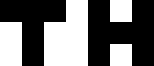

In [2]:
T = Bool[0 0 0; 1 0 1; 1 0 1]
H = Bool[0 1 0; 0 0 0; 0 1 0]

mosaicview(Gray.(T), Gray.(H); nrow=1, npad=1, fillvalue=1)

Now, let's train a model using these images:

In [3]:
X, y = stack(vec(T), vec(H)), ["T", "H"]

model = MultiDiscriminatorClassifier{String}(3; seed=1)

train!(model, X, y)

We can test and see that the trained model is able to correctly classify the training images: 

In [4]:
predict(model, X)

2-element Array{String,1}:
 "T"
 "H"

In [5]:
predict_response(model, X)

Dict{String,Array{Int64,1}} with 2 entries:
  "T" => [3, 0]
  "H" => [0, 3]

Being able to classify images already seen during training, however, is not very impressive. What is truly of interest to us is seeing how this model fares agains never before seen images. Let's prepare some novel data and test it out!

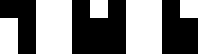

In [6]:
kinda_T = Bool[0 0 1; 1 0 1; 1 0 1]
kinda_H = Bool[0 1 0; 0 0 0; 0 0 0]
kinda_nothing = Bool[1 0 1; 1 0 0; 1 0 0]

mosaicview(Gray.(kinda_T), Gray.(kinda_H), Gray.(kinda_nothing); nrow=1, npad=1, fillvalue=1)

In [7]:
X_test = stack(map(vec, [kinda_T, kinda_H, kinda_nothing])...)

predict(model, X_test)

3-element Array{String,1}:
 "T"
 "H"
 "T"

In [8]:
predict_response(model, X_test)

Dict{String,Array{Int64,1}} with 2 entries:
  "T" => [2, 0, 1]
  "H" => [0, 2, 0]

The responses show us that even tough they don't perfectly fit the model's concept of the characters, it reasonably classifies the first two images as a 'T' and an 'H', respectively. The last one may not look like any particular character for most of us, but ends up being classified as a 'T', altough its response is small and could be interpreted as a classification with low confidence.

## 2. Going beyond toy examples: classification of handwritten digits

At this point, the results shown above may not seen that impressive. Truly, they are not. distinguishing between images made of 9 measly pixels is not a hard task at all. However, weightless neural networks are in no way limited to such low dimension problems. Since its inception, these models have been employed at considerably harder tasks. One higher-dimensional example (that still does not represent an upper limit of the paradigm) is the classification of handwritten digits from the MNIST dataset.

In [9]:
X_train = permutedims(reshape(MNIST.traintensor(), 784, :)) .> 0.5
y_train = MNIST.trainlabels()

X_test = permutedims(reshape(MNIST.testtensor(), 784, :)) .> 0.5
y_test = MNIST.testlabels()

model_digits = MultiDiscriminatorClassifier(28; seed=2)

time_train!(model, X, y) = @btime train!($model, $X, $y)

# time_train!(model_digits, X_train, y_train)
train!(model_digits, X_train, y_train)

In [10]:
time_accuracy(y_pred, y_target) = @btime accuracy($y_pred, $y_target)

time_accuracy (generic function with 1 method)

In [11]:
time_accuracy(predict(model_digits, X_test), y_test)

  5.040 μs (3 allocations: 5.55 KiB)


0.8357

This result is similar to what I get with `wisardpkg` with bleaching **deactivated** but worst then the accuracy when it's activated. Bleaching could be understood as a disambiguation technique, for when there is a tie between discriminators' responses during classification. Before making use of bleaching, it would be interesting to measure the frequency of draws in the classfication of this test set:

In [12]:
ambiguity(values(predict_response(model_digits, X_test))...)

0.1479

More then **14%** of the test images are tying and we should assume that a good number of them are being misclassified.

The models used so far have at their core RAM neurons that address single-bit words. If instead we make use of neurons that address multi-bit words, we could associate to every possible input pattern to that neuron not only its occurance in the dataset but also its frequency. These frequencies give us an extra dimension in comparing discriminators and may be used as a disambiguation mechanism. One way in which the frequencies are used is by defining a bleaching threshold **b** for the neuron. In such a scheme an input pattern activates the neuron only with its observed frequency during training was greater than **b**. Notice that we can achieve the same activation behavior  of the previously seen neurons by setting **b** to zero.

`BleachingDiscriminator` is one that makes use of `AccNode` neurons, where each address is associated with a counter. Classifiers that make use of this discriminator may specify a bleaching threshold as explained above during prediction. For example, training such a bleaching-enabled classifier with the MNIST dataset and using a bleaching threshold of 4, we can attain a considerable gain in accuracy:

In [13]:
model_bleaching = MultiDiscriminatorClassifier{Int64,BleachingDiscriminator}(28; seed=2)

train!(model_bleaching, X_train, y_train)

In [14]:
time_accuracy(predict(model_bleaching, X_test; b=4), y_test)

  5.035 μs (3 allocations: 5.55 KiB)


0.9145

We can also see that the ambiguity went down:

In [15]:
ambiguity(values(predict_response(model_bleaching, X_test; b=4))...)

0.0453

What we have done just now was manually setting a bleaching threshold that was used for all test patterns. However, different patterns may require different levels of bleaching. Additionally, is it really necessary for us to select it manually? Truly, we can achieve a better classification performance if we select thresholds on a case by case basis and we can employ a simple and automatic selection strategy instead of doing it by hand:

In [16]:
time_accuracy(predict(model_bleaching, X_test; b=:linear), y_test)

  5.053 μs (3 allocations: 5.55 KiB)


0.921